In [1]:
import psvWave
import numpy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter


model = psvWave.fdModel("default_testing_configuration.ini")

Loading configuration file: 'tests/test_configurations/default_testing_configuration.ini'.
Parsing passed configuration.


This notebook shows how to use psvWave to do a Full-Waveform Inversion using the L-BFGS algorithm.

Create a target model:

In [2]:
background_values = numpy.array([2000, 800, 1500])

# Create target model ---------------------------------------------------------

# Get the coordinates of every grid point
IX, IZ = model.get_coordinates(True)
extent = model.get_extent(True)
# Get the associated parameter fields
vp, vs, rho = model.get_parameter_fields()

field_shape = vp.shape

vp_starting = numpy.ones(field_shape) * background_values[0]
vs_starting = numpy.ones(field_shape) * background_values[1]
rho_starting = numpy.ones(field_shape) * background_values[2]

x_middle = (IX.max() + IX.min()) / 2
z_middle = (IZ.max() + IZ.min()) / 2

circle = ((IX - x_middle) ** 2 + (IZ - z_middle) ** 2) ** 0.5 < 15
vs = vs_starting * (1 - 0.1 * circle)
vp = vp_starting * (1 - 0.1 * circle)

vp_target = vp.copy()
vs_target = vs.copy()
rho_target = rho.copy()

model.set_parameter_fields(vp_target, vs_target, rho_target)

Show the model:

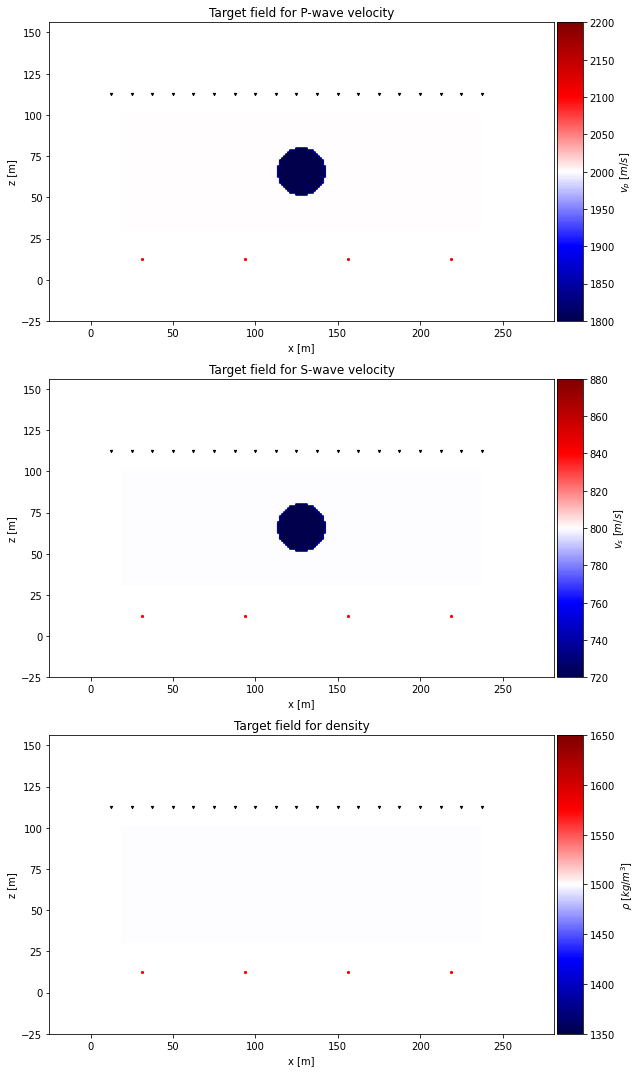

In [3]:
plt.figure(figsize=(9, 15))
plt.tight_layout()
axes = [plt.subplot(3, 1, i + 1) for i in range(3)]

parameters = ["P-wave velocity", "S-wave velocity", "density"]
[
    axis.set_title(f"Target field for {parameter}")
    for axis, parameter in zip(axes, parameters)
]

_ = model.plot_model_vector(
    model.get_model_vector(),
    axes=axes,
    vmin=background_values * 0.9,
    vmax=background_values * 1.1,
)

Plot the data:

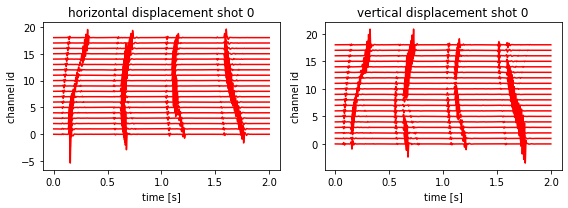

In [4]:
# Create true data ------------------------------------------------------------

for i_shot in range(model.n_shots):
    model.forward_simulate(i_shot, omp_threads_override=6)

# Cheating of course, as this is synthetically generated data.
ux_obs, uz_obs = model.get_synthetic_data()

model.set_observed_data(ux_obs, uz_obs)

model.plot_observed_data()

In [5]:
# Reverting the model to the starting model -----------------------------------

vp = vp_starting
vs = vs_starting
rho = rho_starting

model.set_parameter_fields(vp_starting, vs_starting, rho_starting)

for i_shot in range(model.n_shots):
    model.forward_simulate(i_shot, omp_threads_override=6)

ux, uz = model.get_synthetic_data()
ux_obs, uz_obs = model.get_observed_data()

max_waveform = max(ux.max(), uz.max(), ux_obs.max(), uz.max()) / 2

m_ux_obs = ux_obs.copy()
m_ux = ux.copy()

for i in range(ux_obs.shape[1]):
    m_ux_obs[0, i:, :] += max_waveform
    m_ux[0, i:, :] += max_waveform

Plot the initial gradients:

In [6]:
# Perform adjoint simulation --------------------------------------------------

model.calculate_l2_misfit()

print(f"Data misfit: {model.misfit:.2f}")

model.calculate_l2_adjoint_sources()
model.reset_kernels()
for i_shot in range(model.n_shots):
    model.adjoint_simulate(i_shot, omp_threads_override=6)
model.map_kernels_to_velocity()

g_vp, g_vs, g_rho = model.get_kernels()

extrema = numpy.abs(g_vp).max(), numpy.abs(g_vs).max(), numpy.abs(g_rho).max()

extent = (extent[0], extent[1], extent[3], extent[2])

gradients = [g_vp, g_vs, g_rho]

Data misfit: 1380376.03


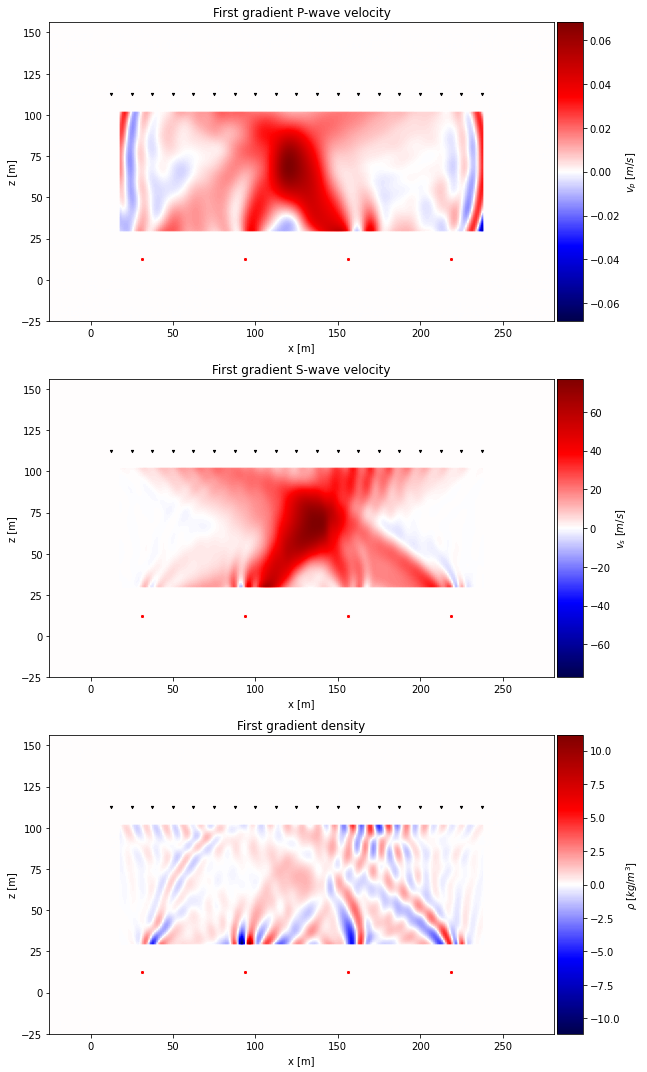

In [7]:
plt.figure(figsize=(9, 15))
plt.tight_layout()
axes = [plt.subplot(3, 1, i + 1) for i in range(3)]

[
    axis.set_title(f"First gradient {parameter}")
    for axis, parameter in zip(axes, parameters)
]

extrema = numpy.array([numpy.abs(g).max() for g in gradients])
_ = model.plot_fields(gradients, vmin=-extrema, vmax=extrema, axes=axes)

Wrap everything up in a class for the SciPy algorithm:

In [8]:
class _fwi:

    last_model = None
    misfit = None
    g = None

    def __init__(self, m):
        self.last_model = numpy.empty_like(m)

    def misfit(self, m):

        if numpy.allclose(m, self.last_model):
            return self.misfit
        else:
            _ = self.grad(m)
            return self.misfit

    def grad(self, m):

        if numpy.allclose(m, self.last_model):
            return self.g
        else:
            model.set_model_vector(m)

            # Simulate forward
            for i_shot in range(model.n_shots):
                model.forward_simulate(i_shot, omp_threads_override=6)

            # Calculate misfit and adjoint sources
            model.calculate_l2_misfit()
            model.calculate_l2_adjoint_sources()
            self.misfit = model.misfit

            # Simulate adjoint
            model.reset_kernels()
            for i_shot in range(model.n_shots):
                model.adjoint_simulate(i_shot, omp_threads_override=6)
            model.map_kernels_to_velocity()

            g = model.get_gradient_vector()
            g = numpy.hstack(
                [
                    gaussian_filter(igs.reshape((60, 180)), sigma=2).flatten()
                    for igs in numpy.split(g, 3)
                ]
            )

            self.g = g

            self.last_model = m

            return self.g

Run 50 iterations

In [9]:
m = model.get_model_vector()
fwi = _fwi(m)

model.set_parameter_fields(vp_starting, vs_starting, rho_starting)

m = model.get_model_vector()

res = minimize(
    fwi.misfit,
    m,
    method="L-BFGS-B",
    jac=fwi.grad,
    options={"gtol": 1e-6, "disp": True, "maxiter": 50},
)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        32400     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38038D+06    |proj g|=  7.57680D+01

At iterate    1    f=  7.83394D+05    |proj g|=  6.56536D+01

At iterate    2    f=  4.71212D+05    |proj g|=  5.62182D+01

At iterate    3    f=  1.34845D+05    |proj g|=  2.01023D+01

At iterate    4    f=  9.09419D+04    |proj g|=  1.47263D+01

At iterate    5    f=  3.44965D+04    |proj g|=  5.35329D+00

At iterate    6    f=  2.11064D+04    |proj g|=  4.02499D+00

At iterate    7    f=  1.30392D+04    |proj g|=  2.76584D+00

At iterate    8    f=  1.00620D+04    |proj g|=  1.65583D+00

At iterate    9    f=  8.81586D+03    |proj g|=  1.21251D+00

At iterate   10    f=  7.43615D+03    |proj g|=  1.09603D+00

At iterate   11    f=  5.92680D+03    |proj g|=  9.52989D-01

At iterate   12    f=  5.35553D+03    |proj g|=  9.68547D-01

At iterate   13    f=  4.7

Plot the final model.

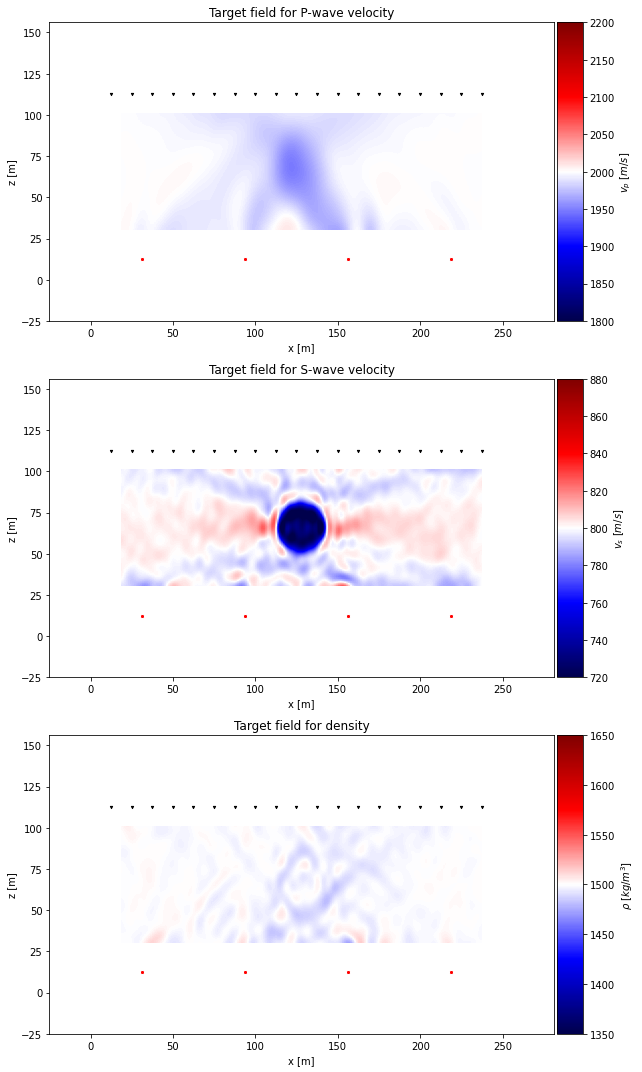

In [11]:
# Start iterating -------------------------------------------------------------

m = model.get_model_vector()


plt.figure(figsize=(9, 15))
plt.tight_layout()
axes = [plt.subplot(3, 1, i + 1) for i in range(3)]

parameters = ["P-wave velocity", "S-wave velocity", "density"]
[
    axis.set_title(f"Target field for {parameter}")
    for axis, parameter in zip(axes, parameters)
]

_ = model.plot_model_vector(
    model.get_model_vector(),
    axes=axes,
    vmin=background_values * 0.9,
    vmax=background_values * 1.1,
)
plt.show()